# Know Your Meme
> Playing around with mulit-category data to classify memes from a chat

- toc: true
- badges: true
- comments: true
- author: Matt Bowen
- categories: [jupyter]
- comments: true

## Introduction

In previous blog entries, I have focused on natural language processing (i.e. text) for the dives into the [fastai course](https://course.fast.ai/). Today, instead, I finally bit the bullet and shifted to working on a computer vision (i.e. images) project.  In particular, I'm going to train a model that handles classificaton of images with mutiple categories.

The data today comes from the same Google Hangouts extraction that I have used before (from [Google Takeout](https://takeout.google.com/).  However, I'm switching my focus from the text in the chat to all of the images that appear in the conversation. I had previously lazily marked these all as "memes" (specifically as "\<MEME\>") in terms of how they would appear as text, but a closer look revealed that is an over-simplification of the images.  

The images contain a wide variety of types and I'm set on using them to train this multiple category model. Among the categories I'm considering are the sender of the image and whether it is a meme or a twitter post or a news article. But I'll cover that in a few minutes.


## Data Preparation

As you may recall, the chat converstation log comes from a Google Takeout download, where the primary source of the log is a `json` file.  The `json` file contains a dictionary of `events`, any of which could correspond to a chat message, a link, an image, or something like a receipt notification. 

Again, we start by loading the `json` data into Python and narrow the data to the events corresponding to actual chat content:

In [1]:
import json

# Load the data from the chatfile
json_filename = "./Hangouts_20201001.json"
json_file = open(json_filename, encoding='utf8')
data = json.load(json_file)
json_file.close()

# Set of keys to descend json tree to chat content
eventKeys = ("conversations", 5, "events")

# Chat content events
events = data
for k in eventKeys:
    events = events[k]

As before, each sender ID maps to a person, whose pseudonym is below:

In [2]:
# Match IDs to names
sender_lookup = {"108076694707330228373": "Kappa",
                 "107112383293353696822": "Beta",
                 "111672618051461612345": "Omega",
                 "112812509779111539276": "Psi",
                 "114685444329830376810": "Gamma",
                 "112861108657200483380": "Sigma"}

There are at least two different ways that images can show up in the chat event log. One is as an embedded attachment and another is as a link. (If there are others, they are ignored for the purposes of this experiment.) In both cases, the log provides a url link to the image that can be downloaded. 

First step is to loop through the events to download each image locally and construct a way to reference each image. I used the `download_url` routine in `fastai` for the former and a csv file for the latter with appropriate info. The description of the csv headers is in the code below that sets up the csv file for writing.

The course lesson that talked about [Pandas](https://pandas.pydata.org/), which I never used or heard of before. I'm going to use it through to maniuplate the csv-like tables. With that in mind, the initial construction may seem a bit odd.

In [ ]:
from fastai.vision.all import *  # Pandas is in the fastai package

# Headers for the csv file
columnHeaders = ["sender",    # Image sender
                  "filename",  # Image filename
                  "type",      # Image type as labeled by Google
                  "timestamp", # Sent timestamp
                 ]

Then, here's the code for looping through the `json` events, downloading each image, and adding a line to the dataframe for each image

In [4]:
##
# Do a count of how many images for each sender
senderCounts = dict()

# Index for filename
imageIndex = 0

# Path for images
imagesPath = "/storage/chat_memes"

# These indexes turned out not to be images (e.g. not all links are images)
badImages = [119, 196, 1000, 1003, 1052, 1455, 1552, 1699]

rows = []

for event in events:
    # Get the ontent of each message (if it exists)
    msgContent = event.get("chat_message",{}).get("message_content",{})
    # Timestamp of message
    timestamp = int(event["timestamp"])
    # Message sender
    sender = event["sender_id"]["gaia_id"]
    sender = sender_lookup[sender]
    
    # Images as attachments
    attachments = msgContent.get("attachment",[])
    for attachment in attachments:
        if imageIndex not in badImages:
            item = attachment["embed_item"]
            itemType = item["plus_photo"]["media_type"] # Usually PHOTO
            itemUrl = item["plus_photo"]["url"]
            filename = f"{imagesPath}/image_{imageIndex:04}"
            download_url(itemUrl, filename, timeout=10, retries=20, show_progress=False)
            rows.append({"timestamp": timestamp, "sender": sender, "filename": filename, "type": itemType})
            senderCounts[sender] = senderCounts.get(sender, 0) + 1
        imageIndex += 1
        
    # Images as links
    segments = msgContent.get("segment",[])
    for segment in segments:
        if segment["type"] == "LINK":
            url = segment["text"]
            base = url.split('/')[-1]
            # Check if it's possibly an image
            if 'jpg' in base or 'gif' in base or 'png' in base:
                if imageIndex not in badImages:
                    filename = f"{imagesPath}/image_{imageIndex:04}"
                    download_url(url, filename, timeout=10, retries=20, show_progress=False)
                    rows.append({"timestamp": timestamp, "sender": sender, "filename": filename, "type": "LINK"})
                    senderCounts[sender] = senderCounts.get(sender, 0) + 1
                imageIndex += 1   

In [5]:
##
# Use rows to create a Pandas dataframe
images_df = pd.DataFrame(rows, columns=columnHeaders)
# Save the rows to a csv file
images_df.to_csv("chat_images.csv")
# Display the first five rows
images_df.head()

,sender,filename,type,timestamp
0,Kappa,/storage/chat_memes/image_0000,PHOTO,1600741647230976
1,Gamma,/storage/chat_memes/image_0001,PHOTO,1600772605984217
2,Psi,/storage/chat_memes/image_0002,PHOTO,1600786824022176
3,Gamma,/storage/chat_memes/image_0003,PHOTO,1600861187519443
4,Kappa,/storage/chat_memes/image_0004,PHOTO,1600863157273002


I ended up with about 1700 images from the chat log. Here's a quick breakdown of how many each sender was responsible for:

In [6]:
totalImages = 0
for sender in senderCounts:
    totalImages += senderCounts[sender]
print(f"Total images: {totalImages}")

for sender in senderCounts:
    images = senderCounts[sender]
    percent = 100 * images / totalImages
    print(f"{sender} sent {images} images -> {percent:.03}%")

Total images: 1718
Kappa sent 707 images -> 41.2%
Gamma sent 294 images -> 17.1%
Psi sent 299 images -> 17.4%
Beta sent 95 images -> 5.53%
Omega sent 322 images -> 18.7%
Sigma sent 1 images -> 0.0582%


And here's a sample image

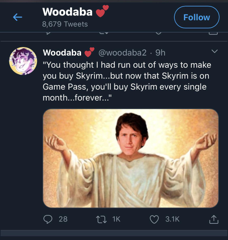

In [7]:
im = Image.open(f"{imagesPath}/image_0000")
im.to_thumb(240)

As might be clear by this point, one clear drawback to using this data to for "multi-category" classification is that the data is really labeled with more than one category (`sender` is really the only usable one). 

The approach that I ended up using to label the day was to just label the data myself {% fn 1 %}. I didn't want to go through each of the 1700 images one by one and apply labels, but I found a tool called [pigeon](https://github.com/agermanidis/pigeon) that was incredibly useful to enable this labeling to take until the heat death of the universe to complete. It still took multiple hours :weary:, but I learned a new tool :sunglasses:.

Before that, though, I needed some labels to apply to the images. After some trials and errors, these are the set I ended up with (along with a brief description of each one.) 

In [8]:
labels = ['meme', # Is it a meme
          'social_media', # Is it a screenshot from social media (usually twitter, sometimes reddit or fb)
          'comic_strip', # Is it a multi-panel comic (usually xkcd or SMBC)
          'game_of_thrones',  # Still mad about the final season
          'simpsons', # Enough Simpsons memes to be on their own
          'rick_and_morty', # Enough Rick & Morty memes to be on their own
          'tv_cartoon', # But not enough South Park, Futurama, or Family Guy to train alone (every simpsons and rick_and_morty is marked this too)
          'star_trek_wars', # Combined star trek and wars to get enough
          'marvel', # Avengers and others memes 
          'lotr', # One does not simply something, something
          'news', # Is this a news item (rather than a humorous one)
          'ali_express', # One member of the chat posts weird things from Ali Express
          'photo', # Is this a real-life photo (as opposed to an internet one)
          'trump', # Is this trump-related
          'beacon', # Is this a beacon for playing video games
          'weird' # random label I put on stuff I thought was unusual, even for us
         ]

With these labels in hand, we can then use pigeon to annotate each image with a label

In [9]:
from pigeon import annotate
from IPython.display import display
import glob

imagesPath = "/storage/chat_memes"
images = glob.glob(imagesPath+"/image*")

annotations = annotate(images, options = labels, display_fn=lambda filename: display(Image.open(filename).to_thumb(240)))

HTML(value='0 examples annotated, 1727 examples left')

Dropdown(options=('meme', 'social_media', 'comic_strip', 'game_of_thrones', 'simpsons', 'rick_and_morty', 'tv_…

Output()

In [10]:
#hide
annotations = {}
all_labels = dict()
with open('annotations') as file:
    for line in file:
        line = line.replace("/notebooks/fastbook/images/","/storage/")
        line = line.replace("ali_express", "ali")
        line = line.replace("ali","ali_express")
        line = line.replace("twitter","social_media")
        line = line.replace("game_of_thrones", "game_of_throne")
        line = line.replace("game_of_throne", "game_of_thrones")
        line = line.replace("star_trek", "star_trek_wars")
        line = line.replace("star_wars", "star_trek_wars")
        line = line.replace("cartoon", "comic_strip")
        line = line.replace("simpsons", "simpsons tv_cartoon")
        line = line.replace("rick_and_morty", "rick_and_morty tv_cartoon")
        line = line.replace("bl3","")
        for show in ["family_guy", "futurama", "south_park", "big_mouth"]:
            line = line.replace(show, "tv_cartoon")
        (filename, labels) = line.split(",")
        labels = set(labels.split())
        for label in labels:
            all_labels[label] = all_labels.get(label, 0) + 1
        annotations[filename] = list(labels)   

Alternatively, by setting `options` to `None`, you can use free-form text for the labels. I ended up using the labels list for the first pass to give each image a label and then the free-form version for adding additional labels. In the end, `annotations` is a Python dictionary mapping a filename to a list of string labels. I saved these to their own pandas dataframe and csv, so as not to lose any of the annotations I made.

In [11]:
rows = []
for filename, labels in annotations.items():
    labels = " ".join(labels)
    rows.append({"filename": filename, "labels": labels})

annotations_df = pd.DataFrame(rows)    
annotations_df.to_csv("annotations.csv")
annotations_df.head()

,filename,labels
0,/storage/chat_memes/image_0029,meme simpsons tv_cartoon
1,/storage/chat_memes/image_0071,meme simpsons tv_cartoon trump
2,/storage/chat_memes/image_0096,meme tv_cartoon
3,/storage/chat_memes/image_0105,meme tv_cartoon
4,/storage/chat_memes/image_0231,meme tv_cartoon


And merge it with the images dataframe I had made earlier:

In [12]:
combined_df = images_df.merge(annotations_df, on='filename')
combined_df.to_csv("chat_memes_with_labels.csv")
combined_df.head()

,sender,filename,type,timestamp,labels
0,Kappa,/storage/chat_memes/image_0000,PHOTO,1600741647230976,social_media
1,Gamma,/storage/chat_memes/image_0001,PHOTO,1600772605984217,social_media
2,Psi,/storage/chat_memes/image_0002,PHOTO,1600786824022176,social_media
3,Gamma,/storage/chat_memes/image_0003,PHOTO,1600861187519443,social_media
4,Kappa,/storage/chat_memes/image_0004,PHOTO,1600863157273002,comic_strip


Finally, this gives us some data that I can work with to get onto the multi-category classification. Whew!

## Multi-category Classification

Following the example in the lesson, I can now create a `DataBlock` object to feed into a `DataLoaders` object to a neural network learner. First, I need some functions to specify my independent and dependent variables. The independent ones are the images/memes and the dependent ones are the sender and the labels that I just annotated above {% fn 2 %}.

In [13]:
def get_x(row):
    return row['filename']
def get_y(row):
    if row['sender'] == 'Sigma':
        return row['labels'].split()
    else:
        return row['labels'].split() + [row['sender']]

These facilitate building the `DataBlock` that can be put into a `DataLoaders`:

In [14]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                   get_x = get_x, 
                   get_y = get_y, 
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(combined_df)

As a reward for reading this far, here's a batch of memes with their labels that the Dataloaders generates. Note that the `RandomResizedCrop` transform is why the display below is a cropped portion of the image. As I understand it, it's designed to normalize the input data to prevent effects of image size and dimension from having an influence on training the model.

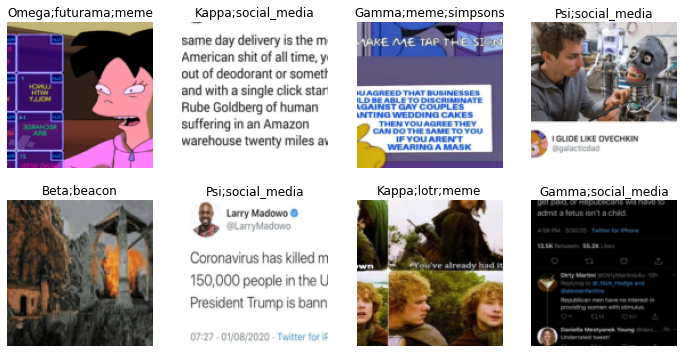

In [54]:
dls.show_batch(nrows=2, ncols=4)

Create a learner module from the loaded data:

In [15]:
learn = cnn_learner(dls, resnet18)

The default metric for multi-category labelled data is `accuracy_multi` which uses a [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) with a particular threshold to decide whether or not an image gets a particular label. 

I had no idea what the learning rate or threshold should be for this data, so I tried to used their approaches to use the data to determine what the learning rate and threshold should be.

First, the learning rate:

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.03981071710586548)

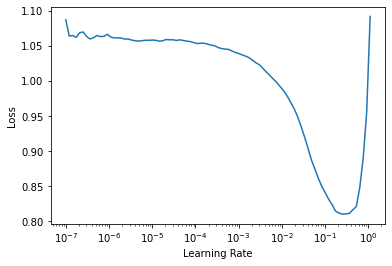

In [16]:
learn.lr_find()

The suggested learning rate looks to be 0.03 or 0.04 is called for. Now, for the threshold for accuracy_multi:

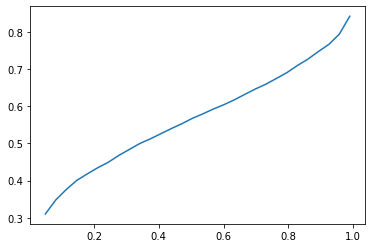

In [17]:
preds,targs = learn.get_preds()
xs = torch.linspace(0.05, 0.99,30)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

Unfortunately, I did not get any sort of peak in curve. Any speculation as to why on my part at this point would be a wild guess. So, I picked a somewhat random value of 0.8 for the threshold.

In [18]:
lr = 0.04
threshold = 0.8
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=threshold))
learn.fine_tune(3, base_lr=lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.665638,0.417254,0.898459,00:47


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.263506,0.572447,0.889776,01:00
1,0.236928,0.222640,0.918207,00:59
2,0.211741,0.180523,0.926891,00:59


Next, I saved the model so I can use it later, without having to retrace all of the above steps

In [19]:
learn.export("meme_classification.pkl")

### Inference

Now, with a trained model, I can try to make predictions. I need some data to actually infer on. Fortunately, since I am taking my sweet time going through the course, I had two more months of chat images (471 in total) that I could use for that.

I used the same process as above to import the images from the `json` file, but now, I only considered messages that had timestamps that were greater than the last timestamp from the training and validation set. I stored those images along with their senders in a new `Pandas` data frame and save it to a csv.

In [21]:
#hide
import json
from fastai.vision.all import *  

# Load the data from the chatfile
json_filename = "./Hangouts_20201228.json"
json_file = open(json_filename, encoding='utf8')
data = json.load(json_file)
json_file.close()

# Set of keys to descend json tree to chat content
eventKeys = ("conversations", 4, "events")

# Chat content events
events = data
for k in eventKeys:
    events = events[k]

# Match IDs to names
sender_lookup = {"108076694707330228373": "Kappa",
                 "107112383293353696822": "Beta",
                 "111672618051461612345": "Omega",
                 "112812509779111539276": "Psi",
                 "114685444329830376810": "Gamma",
                 "112861108657200483380": "Sigma"}

# Headers for the csv file
new_image_column_headers = ["sender", "filename", "type", "timestamp"]

# Index for filename
image_index = 0

# Path for images
new_images_path = "/storage/chat_memes/new_images"

new_image_rows = []

sender_counts = dict()

min_timestamp = 1601567575837527
for event in events:
    # Get the ontent of each message (if it exists)
    msg_content = event.get("chat_message",{}).get("message_content",{})
    # Timestamp of message
    timestamp = int(event["timestamp"])
    if timestamp < min_timestamp:
        continue

    # Message sender
    sender = event["sender_id"]["gaia_id"]
    sender = sender_lookup[sender]
    
    # Images as attachments
    attachments = msg_content.get("attachment",[])
    for attachment in attachments:
        item = attachment["embed_item"]
        item_type = item["plus_photo"]["media_type"] # Usually PHOTO
        item_url = item["plus_photo"]["url"]
        filename = f"{new_images_path}/image_{image_index:04}"
        download_url(item_url, filename, timeout=10, retries=20, show_progress=False)
        if image_index == 99 or image_index == 471:
            print(filename)
        new_image_rows.append({"timestamp": timestamp, "sender": sender, "filename": filename, "type": item_type})
        sender_counts[sender] = sender_counts.get(sender, 0) + 1
        image_index += 1
        
    # Images as links
    segments = msg_content.get("segment",[])
    for segment in segments:
        if segment["type"] == "LINK":
            url = segment["text"]
            base = url.split('/')[-1]
            # Check if it's possibly an image
            if 'jpg' in base or 'gif' in base or 'png' in base:
                filename = f"{new_images_path}/image_{image_index:04}"
                download_url(url, filename, timeout=10, retries=20, show_progress=False)
                new_image_rows.append({"timestamp": timestamp, "sender": sender, "filename": filename, "type": "LINK"})
                sender_counts[sender] = sender_counts.get(sender, 0) + 1
                image_index += 1  

In [22]:
##
# Use rows to create a Pandas dataframe
new_images_df = pd.DataFrame(new_image_rows, columns=new_image_column_headers)
# Display the first five rows
new_images_df.head()

,sender,filename,type,timestamp
0,Beta,/storage/chat_memes/new_images/image_0000,PHOTO,1607981480934474
1,Gamma,/storage/chat_memes/new_images/image_0001,PHOTO,1607991667741774
2,Omega,/storage/chat_memes/new_images/image_0002,PHOTO,1608007771189618
3,Kappa,/storage/chat_memes/new_images/image_0003,PHOTO,1608041280956958
4,Kappa,/storage/chat_memes/new_images/image_0004,PHOTO,1608081802164842


For the 472 new images, the breakdown of senders was `{'Kappa': 222, 'Psi': 95, 'Gamma': 71, 'Omega': 63, 'Beta': 20}`. After my labeling quagmire above, I didn't bother trying to otherwise label the new data, but just looked at a few samples instead, which I'll show below.

First, let's get the sender and labels predictions for each of the new images into a `Pandas` data frame:

In [23]:
##
# Senders (RSVP Sigma)
senders = set(['Kappa', 'Gamma', 'Psi', 'Beta', 'Omega'])
# Column headers
predict_column_headers = ['filename', 'predict_sender', 'predict_labels']
# One row for each file
predict_rows = []

for image_file in new_images_df['filename']:
    # no_bar prevents a progress appearing for each predict call
    with learn.no_bar():
        labels = learn.predict(image_file)
    all_labels = set(labels[0])
    
    sender = all_labels.intersection(senders)
    other_labels = all_labels.difference(sender)
    
    if '471' in image_file:
        print(image_file)
    
    row = {}
    row['filename'] = image_file
    if len(sender) > 0:
        row['predict_sender'] = " ".join(sender)
    if len(other_labels) > 0:
        row['predict_labels'] = " ".join(other_labels)
    predict_rows.append(row)
    
# Use rows to create a Pandas dataframe
predict_df = pd.DataFrame(predict_rows, columns=predict_column_headers)
# Display the first five rows
predict_df.head()

,filename,predict_sender,predict_labels
0,/storage/chat_memes/new_images/image_0000,NaN,meme
1,/storage/chat_memes/new_images/image_0001,NaN,social_media
2,/storage/chat_memes/new_images/image_0002,Omega,ali_express
3,/storage/chat_memes/new_images/image_0003,NaN,meme
4,/storage/chat_memes/new_images/image_0004,Kappa,meme


I'll combine this data frame with the one extracting the new images from the `json` file:

In [24]:
combined_new_images_df = new_images_df.merge(predict_df, on='filename')
combined_new_images_df.to_csv("chat_new_images_predictions.csv")
combined_new_images_df.head()

,sender,filename,type,timestamp,predict_sender,predict_labels
0,Beta,/storage/chat_memes/new_images/image_0000,PHOTO,1607981480934474,NaN,meme
1,Gamma,/storage/chat_memes/new_images/image_0001,PHOTO,1607991667741774,NaN,social_media
2,Omega,/storage/chat_memes/new_images/image_0002,PHOTO,1608007771189618,Omega,ali_express
3,Kappa,/storage/chat_memes/new_images/image_0003,PHOTO,1608041280956958,NaN,meme
4,Kappa,/storage/chat_memes/new_images/image_0004,PHOTO,1608081802164842,Kappa,meme


Some overall observations from the predictions the model made and this table:

Only 259 images actually got labeled with a sender: 199 for Kappa, 56 for Omega, and 4 for Gamma. Beta and Psi were never predicted as a label. Of those 259 sender predictions, 134 were correct. 

20 of the images weren't predicted to have any label (sender or otherwise) at all

I wrote some widget code to display the images with their predicted and correct sender and the predict labels

In [32]:
import ipywidgets as widgets

def vbox_single(number):
    im_file = f"{new_images_path}/image_{number:04}"
    tsender = combined_new_images_df['sender'][number]
    psender = combined_new_images_df['predict_sender'][number]
    plabels = combined_new_images_df['predict_labels'][number]
    w1 = widgets.Label(f"Correct Sender: {tsender}")
    w2 = widgets.Label(f"Predicted Sender: {psender}")
    w3 = widgets.Label(f"Predicted Labels: {plabels}")
    w4 = widgets.Image(value=Image.open(im_file).to_thumb(240).to_bytes_format(), width=240, height=240)
    return widgets.VBox([w1, w2, w3, w4])

Here's some of the ones where the sender was predicted correctly:

In [33]:
indexes = [58, 247, 285, 107, 281, 447]
items = [vbox_single(i) for i in indexes]
widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(3, 300px)"))

GridBox(children=(VBox(children=(Label(value='Correct Sender: Omega'), Label(value='Predicted Sender: nan'), L…

And some of the ones where the sender was predicted incorrectly:

In [34]:
indexes = [466, 122, 152, 213, 313, 310]
items = [vbox_single(i) for i in indexes]
widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(3, 300px)"))

GridBox(children=(VBox(children=(Label(value='Correct Sender: Beta'), Label(value='Predicted Sender: Kappa'), …

And 3 more random ones for the brave reader who got this far:

In [35]:
indexes = [166, 123, 18]
items = [vbox_single(i) for i in indexes]
widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(3, 300px)"))

GridBox(children=(VBox(children=(Label(value='Correct Sender: Gamma'), Label(value='Predicted Sender: nan'), L…

In the images I looked through, the classifier did a pretty good job on appropriately labeling 'social_media', 'meme', 'tv_cartoon', 'comic_strip', 'photo' and 'ali_express' in the same way that I did, but struggled to do the same with the other labels. Again, if I cared more about results (and had better labeled data), I'm sure I could improve the accuracy, but I'm just happy to work through the multi-classification learning to produce something reasonable. MEMES! :satisfied:

{{ "I thought about a few different ways to try to apply categorical labels to the data.  Given that I'm in the midst of a deep learning course, training a model to label the data was an option I considered, but I would essentially have to create a model for each type of category that I wanted, download images for each of those and use the models to classify the chat image data. If I had to do it over again, that is likely the approach I would take. Hindsight is 20/20." | fndetail: 1}}

{{ "The fact that Sigma only sent 1 image meant I couldn't really train to find that label, so I removed Sigma from the possible labels. Sorry Sigma." | fndetail: 2}}